# ACNets: Connectivity Classifier

This notebook fits a binary classifier to predict participant's group, AVGP or NVGP, using functional connectivity matrices. As input, it takes upper-triangular connectivity matrices for each participant.

To address the concerns about small sample size and test/train splits, results are evaluated using 5-fold cross-validated permutation testing.

## 0. Setup

In [30]:

import numpy as np
import xarray as xr
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns; sns.set('poster')
import plotly.express as px

from sklearn import preprocessing, model_selection, metrics, ensemble, multioutput
from sklearn import decomposition, cross_decomposition, feature_selection, dummy, svm

from sklearn.pipeline import Pipeline
# from xgboost import XGBClassifier  # incompatible with umap's scipy

import xgboost
import shap

sns.set(style='dark')

# Technical reproducibility
%reload_ext watermark
%watermark -iv -co -ituhmv

Last updated: 2022-02-18T11:58:35.165210+01:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

conda environment: acnets

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Hostname: MP0159

numpy     : 1.21.5
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:28:27) 
[Clang 11.1.0 ]
xarray    : 0.21.1
sklearn   : 1.0.2
shap      : 0.40.0
pandas    : 1.4.0
xgboost   : 1.5.1
seaborn   : 0.11.2
matplotlib: 3.5.1
plotly    : 5.5.0



### Load the dataset

In [41]:
atlases = ['dosenbach2007', 'difumo_64_2', 'difumo_128_2',]# 'difumo_1024_2']


DATASETS = dict()

for atlas in atlases:
  DATASETS[atlas] = xr.open_dataset(f'data/julia2018_resting/connectivity_{atlas}.nc')

# selected data for the analysis
DEFAULT_ATLAS = 'difumo_64_2'
DEFAULT_DATASET = DATASETS[DEFAULT_ATLAS]
DEFAULT_CONNECTIVITY = DEFAULT_DATASET['tangent_connectivity'].values

DEFAULT_DATASET

<xarray.Dataset>
Dimensions:                           (subject: 34, region: 64, timestep: 125,
                                       difumo_names: 64)
Coordinates:
  * subject                           (subject) object 'AVGP01' ... 'NVGP19NEW'
  * timestep                          (timestep) int64 0 1 2 3 ... 122 123 124
  * difumo_names                      (difumo_names) object 'Superior frontal...
Dimensions without coordinates: region
Data variables: (12/23)
    timeseries                        (subject, region, timestep) float64 ...
    groups                            (subject) object ...
    age                               (subject) float64 ...
    sex                               (subject) object ...
    group                             (subject) object ...
    preprocessed_beh                  (subject) int8 ...
    ...                                ...
    mni152_z                          (difumo_names) float64 ...
    covariance_connectivity           (subject, region, region) float64 ...
    correlation_connectivity          (subject, region, region) float64 ...
    partial_correlation_connectivity  (subject, region, region) float64 ...
    tangent_connectivity              (subject, region, region) float64 -0.24...
    precision_connectivity            (subject, region, region) float64 ...
Attributes:
    description:  Resting state connectivity matrices for difumo_64_2

## 2. Classification Model

-[ ] TODO: replicate https://www.frontiersin.org/articles/10.3389/fnhum.2014.00425/full

In [35]:
# ALT1: single-output classifiers, e.g., SVM, boosting
# model = svm.SVC(kernel='linear', C=1, probability=True)
# model =ensemble.AdaBoostClassifier(model, n_estimators=100, algorithm='SAMME.R')
# model =ensemble.GradientBoostingClassifier(n_estimators=100)

# ALT2: chance level
# model = dummy.DummyClassifier(strategy='uniform')

# ALT3: multi-output (classification + behavioral regression)
# model = multioutput.MultiOutputClassifier(ensemble.GradientBoostingClassifier())


pipeline = Pipeline([
    ('zerovar', feature_selection.VarianceThreshold()),
    # ('select', feature_selection.SelectKBest()),
    # ('rfe', feature_selection.RFE(svc)),
    # ('standard_scaler', preprocessing.StandardScaler()), 
    # ('reducer', UMAP(n_components=3)), 
    # ('reducer', decomposition.PCA()),
    # ('reducer', cross_decomposition.PLSCanonical()),    
    ('model', svm.SVC(kernel='rbf', C=1, probability=True)),
    # ('model', xgboost.XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric='logloss')),
], verbose=False)


param_grid = {
    # 'zerovar__threshold': [0],
    # 'select__k': np.linspace(1, X.shape[1], num=100, endpoint=True, dtype='int'),
    # 'rfe__n_features_to_select': [.1, .2, .5, 1.],
    # 'reducer__n_neighbors': [1, 2, 3, 4, 5, 10],  # UMAP
    # 'reducer__n_components': [2,3,5],  # UMAP
    # 'reducer__n_components': range(1, 10),  # PCA
    # 'model__n_estimators': [10, 100, 1000],  # XGBClassifier, GradientBoostingClassifier
    # 'model__estimator__n_estimators': [10, 100],  # MultiOutputClassifier
}

grid = model_selection.GridSearchCV(
    pipeline, param_grid,
    cv=model_selection.LeaveOneOut(),
    scoring='accuracy',
    # scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'], refit='accuracy',
    n_jobs=-1, verbose=1,
)

# rfe_model = feature_selection.RFECV(grid)
# rfe_model.fit()

Now we tune the hyper-parameters and train the model. We then evaluate the fitted model on the held-out test data:

## 1. Data

In [36]:

_tmp_results = []  # will be converted to DataFrame and deleted later

for ds_name, ds in DATASETS.items():

  # 1. input (vectorized connectivity matrix)
  connectivity = ds['tangent_connectivity'].values
  X = np.array([subj_conn[np.triu_indices_from(subj_conn)] for subj_conn in connectivity])

  # 1.1. threshold X
  X_threshold = np.median(X, axis=1) + np.std(X, axis=1)
  X = np.where(np.abs(X) >= X_threshold.reshape(-1,1), X, 0)

  # 2. output (AVGP vs NVGP encoded as integers)
  y_encoder = preprocessing.LabelEncoder()
  y = y_encoder.fit_transform(ds['group'])

  # 2.1. behavioral outputs (inverse efficiency scores in millis)
  y_beh = ds['inverse_efficiency_score_ms'].values

  # 3. remove subjects with missing behavioral data
  X = X[~np.isnan(y_beh)]
  y = y[~np.isnan(y_beh)]
  y_beh = y_beh[~np.isnan(y_beh)]

  # DEBUG
  print(f'{X.shape[1]} features, {X.shape[0]} subjects, {np.unique(y).shape[0]} class labels.')
  
  train, test = model_selection.train_test_split(
    range(len(X)),
    test_size=0.2,
    shuffle=True,
    stratify=y)

  # fit
  grid.fit(X[train], y[train])

  # evaluate
  score_train = grid.score(X[train], y[train])
  score_test = grid.score(X[test], y[test])

  # clear_output()

  # report scores and hyperparameters
  print(f'{ds_name} - train set score (roc_auc): {score_train:.2f}')
  print(f'{ds_name} - test set score (roc_auc): {score_test:.2f}')
  
  print('Permutation testing...', end=' ')
  
  obs_score, perm_scores, p_value = model_selection.permutation_test_score(
    pipeline, X, y,
    cv=5, scoring='roc_auc',
    #cv=model_selection.LeaveOneOut(), scoring='accuracy',  # LOO cannot handle roc-auc
    n_permutations=1000,
    n_jobs=-1, verbose=0)
  
  _tmp_results.append({
    'dataset': ds_name,
    'observed_score': obs_score,
    'permutation_scores': perm_scores,
    'p_value': p_value,
  })
  
  print('done!')
  print('--------')

print('Finished!')

perm_results = pd.DataFrame(_tmp_results) 

780 features, 32 subjects, 2 class labels.
Fitting 25 folds for each of 1 candidates, totalling 25 fits
dosenbach2007 - train set score (roc_auc): 1.00
dosenbach2007 - test set score (roc_auc): 0.71
Permutation testing... done!
--------
2080 features, 32 subjects, 2 class labels.
Fitting 25 folds for each of 1 candidates, totalling 25 fits
difumo_64_2 - train set score (roc_auc): 1.00
difumo_64_2 - test set score (roc_auc): 0.57
Permutation testing... done!
--------
8256 features, 32 subjects, 2 class labels.
Fitting 25 folds for each of 1 candidates, totalling 25 fits
difumo_128_2 - train set score (roc_auc): 1.00
difumo_128_2 - test set score (roc_auc): 0.57
Permutation testing... done!
--------
Finished!


## 3. Model Evaluation
Below is the confusion matrix of the classifier on the train and test sets.

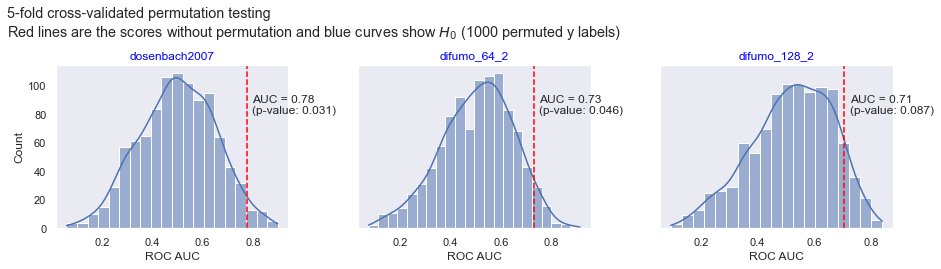

In [37]:

fig, axes = plt.subplots(1, len(perm_results), sharey=True,
                         figsize=(15, 3),
                         gridspec_kw=dict(wspace=.3)
                         )

for i, ds_name, obs_score, scores, p_value in perm_results.itertuples():
  g = sns.histplot(scores, kde=True, ax=axes[i])
  axes[i].axvline(obs_score, ls='--', color='red')

  axes[i].set(xlabel='ROC AUC')
  axes[i].text(x=obs_score + .02,
               y=axes[i].get_ylim()[1] * .7,
            s=(f'AUC = {obs_score:.2f}\n'
               f'(p-value: {p_value:.3f})'))
  
  axes[i].set_title(ds_name, color='blue')

plt.suptitle('5-fold cross-validated permutation testing\n'
             'Red lines are the scores without permutation '
             f'and blue curves show $H_0$ ({len(scores)} permuted y labels)',
             y=1.15, x=.08, ha='left')
plt.show()

In [142]:
import shap

dataset = DATASETS['dosenbach2007']
connectivity = dataset['tangent_connectivity'].values

X = np.array([subj_conn[np.triu_indices_from(subj_conn, k=1)] for subj_conn in connectivity])

y_encoder = preprocessing.LabelEncoder()
y = y_encoder.fit_transform(ds['group'])
y_beh = ds['inverse_efficiency_score_ms'].values

# 3. remove subjects with missing behavioral data
X = X[~np.isnan(y_beh)]
y = y[~np.isnan(y_beh)]
y_beh = y_beh[~np.isnan(y_beh)]

pipeline.fit(X, y)
explainer = shap.Explainer(pipeline.predict, X)
shap_values = explainer(X, max_evals= 2 * X.shape[1] + 1)

Permutation explainer: 33it [01:18,  2.80s/it]                        


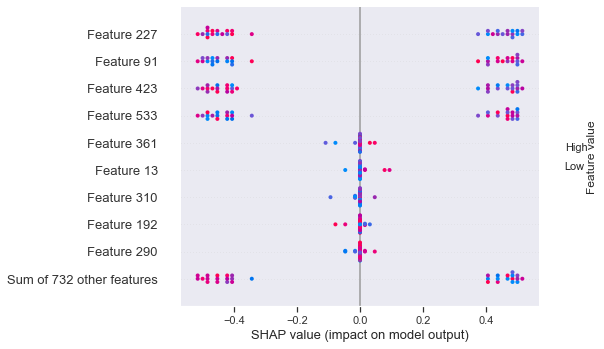

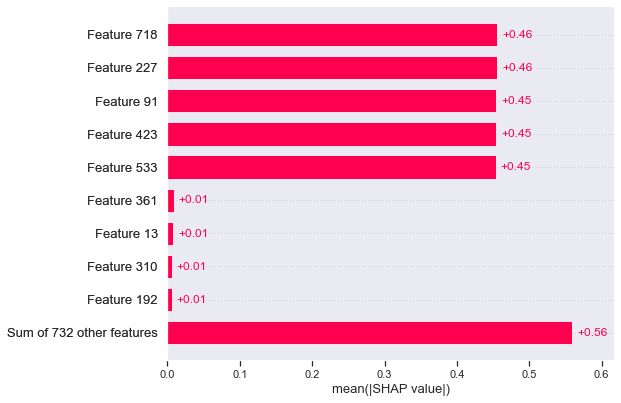

In [175]:
clustering = None # shap.utils.hclust(X, y)

# shap.plots.waterfall(shap_values[1], max_display=10)
shap.plots.beeswarm(shap_values, max_display=10)
shap.plots.bar(shap_values, max_display=10)#, clustering=clustering)

In [182]:
shap2d_size = len(dataset.coords['region'])

shap2d_values = np.zeros((shap2d_size, shap2d_size))
shap2d_triu_indices = np.triu_indices(shap2d_size, k = 1)
shap2d_values[shap2d_triu_indices] = shap_values.sum(0).values
shap2d_values = shap2d_values + shap2d_values.T - np.diag(np.diag(shap2d_values))

shap2d = pd.DataFrame(shap2d_values,
                      index=dataset.coords['region'],
                      columns=dataset.coords['region'])


sorted_shap_indices = np.argsort(shap_values.abs.sum(0).values)[::-1]
top_n = 5
triu_idx = sorted_shap_indices[:top_n]
row_idx = np.triu_indices(shap2d_size, k = 1)[0][triu_idx]
col_idx = np.triu_indices(shap2d_size, k = 1)[1][triu_idx]

# DEBUG make sure indices are mapped correctly
assert np.all(shap2d_values[row_idx,col_idx] == shap_values.sum(0).values[triu_idx])


print('Top contributing connectivities:')
for i, (row, col) in enumerate(zip(row_idx, col_idx)):
  # print(f'{shap2d.index[i]} - {shap2d.columns[j]}')
  print(f'{i+1}) ',
        dataset.coords['region'].values[row], '<->',
        dataset.coords['region'].values[col])


Top contributing connectivities:
1)  L postcingulate <-> L midtemporal
2)  midcingulate <-> L inf cerebellum
3)  R frontal cortetrue <-> L lat cerebellum
4)  dACC/msFC <-> L inf cerebellum
5)  R lat cerebellum <-> L inf cerebellum


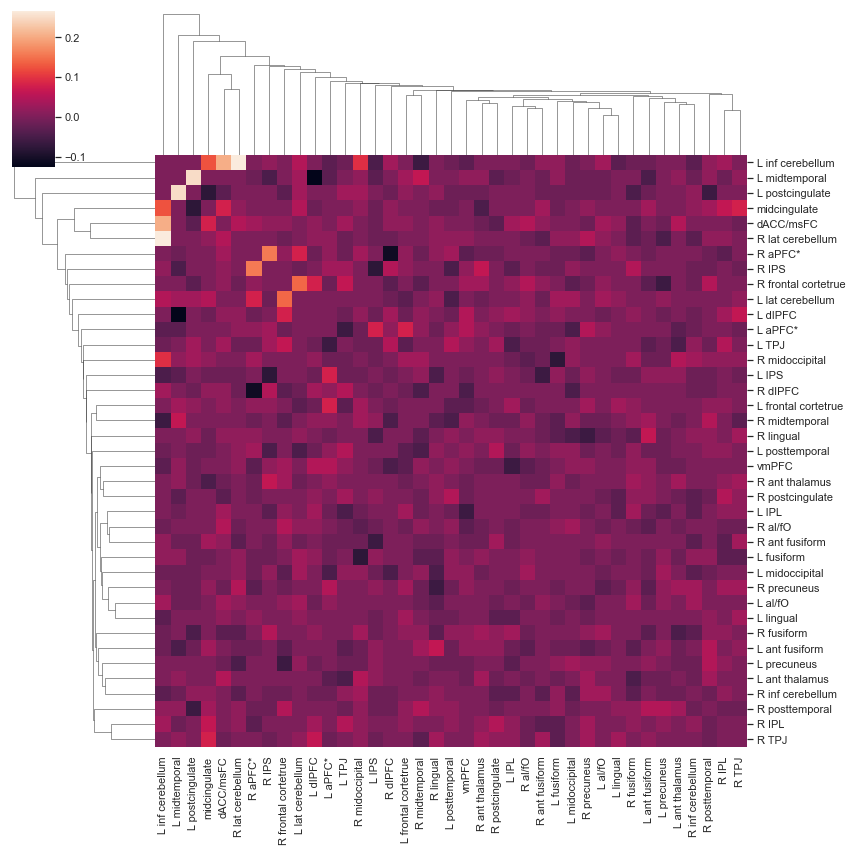

In [183]:
sns.clustermap(shap2d, figsize=(12,12), robust=False)
plt.show()


# interactive heatmap (but not clustered)
# import plotly.express as px
# fig = px.imshow(shap2d, aspect='auto', height=800)
# fig.show()